In [ ]:
import numpy as np
import json
import thulac
import re
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tqdm import tqdm
import cv2 as cv
import os
import glob

In [ ]:
data = np.load('data/data.npy')
labels = np.load('data/labels.npy')

In [3]:
# 为了提高识别的准确率，对数据集进行打乱处理
permutation = np.random.permutation(labels.shape[0])
data = data[permutation, :]
labels = labels[permutation]

In [4]:
#构建RNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(int(data.max() + 1),output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [5]:
# 定义优化器
adam = keras.optimizers.Adam(0.0001)

In [6]:
model.compile(optimizer=adam, 
              metrics=['acc'],
              loss='binary_crossentropy')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          3180864   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,255,233
Trainable params: 3,255,233
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 使用 Tensorboard 作为模型训练监视器，监控过拟合
tensorBoard = keras.callbacks.TensorBoard(log_dir='kerasLog', write_images=1, histogram_freq=1)

In [9]:
history=model.fit(data, labels, batch_size=128, validation_split=0.2, epochs=25, callbacks=[tensorBoard], verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 89s 2ms/sample - loss: 1.1406 - acc: 0.5012 - val_loss: 0.7238 - val_acc: 0.4953
Epoch 2/25
48000/48000 [==============================] - 83s 2ms/sample - loss: 0.6257 - acc: 0.6839 - val_loss: 0.5568 - val_acc: 0.7465
Epoch 3/25
48000/48000 [==============================] - 83s 2ms/sample - loss: 0.5117 - acc: 0.7809 - val_loss: 0.6000 - val_acc: 0.6032
Epoch 4/25
48000/48000 [==============================] - 82s 2ms/sample - loss: 0.4497 - acc: 0.8175 - val_loss: 0.4573 - val_acc: 0.8168
Epoch 5/25
48000/48000 [==============================] - 82s 2ms/sample - loss: 0.4179 - acc: 0.8410 - val_loss: 0.4461 - val_acc: 0.8240
Epoch 6/25
48000/48000 [==============================] - 83s 2ms/sample - loss: 0.3860 - acc: 0.8529 - val_loss: 0.4641 - val_acc: 0.8281
Epoch 7/25
48000/48000 [==============================] - 83s 2ms/sample - loss: 0.4015 - acc: 0.8341 - val_loss: 0.

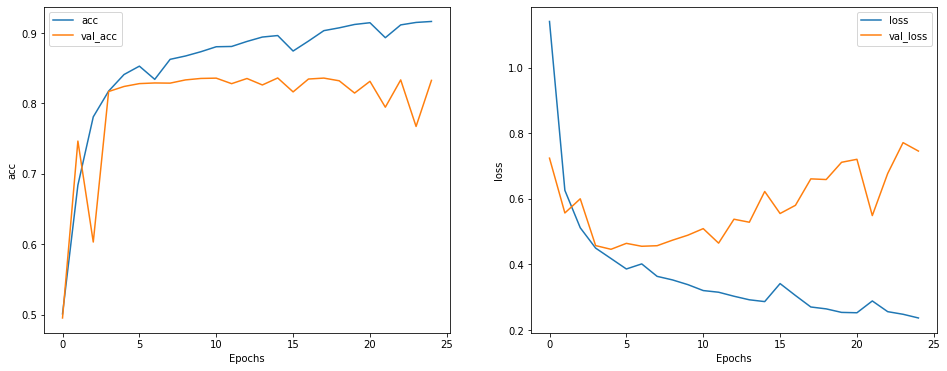

In [10]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [11]:
model.save('model.h5')

In [12]:
model = keras.models.load_model('model.h5')
fin = open('data/word_dict.json', 'r+', encoding='utf8')
word_dict = json.load(fin)
fin.close()

In [13]:
thu = thulac.thulac(seg_only=True, T2S=True, filt=False)
def encodeReview(comment):
    global thu,word_dict

    texts = thu.cut(comment, text=True)
    texts = texts.split(' ')

    encodedReview = np.array([1]) # <START>
    for text in texts:
        if(word_dict.get(text) != None):
            encodedReview = np.append(encodedReview, word_dict[text])
        else:
            encodedReview = np.append(encodedReview, 2) # <UNK>

    return encodedReview

Model loaded succeed


In [14]:
nagativeComment = encodeReview(' 什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏。脑残片好圈钱倒是真的。')
activeComment = encodeReview('机甲之战超超好看，比变形金刚强；人，神，变异人，人工智能互殴，强强强强；每一小段末句都是槽或者笑点，应该死了不少编剧；Jane不来客串，雷神没露，扣分；女神配怪兽，fair enough；美国队长我最喜欢他的盾，大概因为紫龙；难得人物多次发表演讲还不死；最后，找到了下半年新发型，开心！')
# 使用 np.expand_dims 在不改变数据值的情况下扩增一个维度
nagativeComment = np.expand_dims(nagativeComment, axis = 0)
activeComment = np.expand_dims(activeComment, axis = 0)

In [15]:
print(nagativeComment)
print('------')
print(activeComment)

[[    1 32789 46100 46266   715     2  1775 29514  7393 31425 16843 39036
   8721 16111 36402   715 48666 35375 19999 47365 39139  4435 45052 42129
   4439 31936 26083 11615 39139]]
------
[[    1 30954 22786 20183 15023 15491   715  6042 40194 42669 41618 40634
    715 33415   715 21543 36268   715  5585 16520   715 32191 30512 30512
  41618  5230 29912 40392 40535 38600  8709 24261 11722  4539 12686 23186
    715     2 17136  7556     2 47353 41618 20793 24781  2069 14382   715
  44180  1962 39111   715 21900 41618 19833 26432   715 30010  4360 41618
  48807 30229 29161 42637 25559 26732 11615 29025   715 19532 29284 25111
  41618 23473 39384 20792 11129 48666 24781 17136 41618 29964   715 46255
   7556 42023 29116   715 48508 46590]]


In [16]:
nResult = model.predict(nagativeComment)
aResult = model.predict(activeComment)

In [17]:
print(nResult)
if(nResult[0][0] < 0.5):
    print('负面')
else:
    print('正面')

if(aResult[0][0] < 0.5):
    print('负面')
else:
    print('正面')

[[-0.07823405]]
负面
正面
